In [1]:
# Install required libraries
!pip install transformers pytesseract pillow

In [6]:
# Import necessary libraries
from transformers import pipeline
import pytesseract
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageOps
from IPython.display import display
from tabulate import tabulate

# Initialize the spelling correction pipeline
fix_spelling = pipeline("text2text-generation", model="oliverguhr/spelling-correction-english-base")

# Function to preprocess the image and extract text
def preprocess_and_extract_text(image_path):
    # Open the image
    image = Image.open(image_path)

    # Convert the image to grayscale
    grayscale_image = ImageOps.grayscale(image)

    # Apply contrast enhancement to improve OCR accuracy
    enhancer = ImageEnhance.Contrast(grayscale_image)
    enhanced_image = enhancer.enhance(2)  # Increase contrast

    # Perform binarization (convert image to black and white)
    binary_image = enhanced_image.point(lambda x: 0 if x < 128 else 255, '1')

    # Extract text using Tesseract OCR
    text = pytesseract.image_to_string(binary_image)
    return text

# Function to correct spelling in text and capture corrections
def correct_spelling(text):
    corrected_text = fix_spelling(text, max_length=2048)[0]['generated_text']
    return corrected_text

# Function to find and display incorrectly spelt words and their corrections
def highlight_corrections(original_text, corrected_text):
    original_words = original_text.split()
    corrected_words = corrected_text.split()

    corrections = []
    for orig, corr in zip(original_words, corrected_words):
        if orig != corr:
            corrections.append([orig, corr])

    # Display corrections in a tabular form
    if corrections:
        print("\nIncorrectly Spelt Words and Corrections: \n")
        print(tabulate(corrections, headers=["Incorrect Word", "Corrected Word"]))
        print(" ")
    else:
        print("No spelling mistakes found.\n")

# Function to overlay corrected text on the image
def overlay_text_on_image(image_path, corrected_text, output_path):
    img = Image.open(image_path)

    # Convert the image to RGB if it is in RGBA mode
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    draw = ImageDraw.Draw(img)

    # Define font and size for the text overlay
    font = ImageFont.load_default()
    text_color = (0, 0, 0)  # Black color for text

    # Calculate position to center text using textbbox
    text_bbox = draw.textbbox((0, 0), corrected_text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    image_width, image_height = img.size
    text_position = ((image_width - text_width) // 2, (image_height - text_height) // 2)

    # Draw the corrected text on the image
    draw.text(text_position, corrected_text, fill=text_color, font=font)

    # Save the image with overlaid text
    img.save(output_path)
    display(img)

# Function to handle user input and workflow
def process_image_and_correct():
    # Upload an image
    from google.colab import files
    uploaded = files.upload()

    # Get the first uploaded image
    image_path = next(iter(uploaded))

    # Extract text from the image using preprocessing
    extracted_text = preprocess_and_extract_text(image_path)
    print("Extracted Text:")
    print(extracted_text)  # Print extracted text to review

    # Ask user whether to continue with correction
    proceed = input("Do you want to correct the extracted text? (yes/no): ").strip().lower()
    if proceed != "yes":
        print("Exiting without correcting text.")
        return

    # Correct spelling in the extracted text
    corrected_text = correct_spelling(extracted_text)
    print("\nCorrected Text:")
    print(corrected_text)
    print(" ")

    # Highlight and display incorrectly spelt words and their corrections
    highlight_corrections(extracted_text, corrected_text)

    # Overlay corrected text on the image and save it
    output_path = "/content/corrected_image.jpg"  # Modify path as needed
    overlay_text_on_image(image_path, corrected_text, output_path)

    # Provide download link for the corrected image
    print("\nDownload the corrected image:")
    files.download(output_path)

In [4]:
!apt-get install -y tesseract-ocr


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,968 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

Saving testt2.png to testt2.png
Extracted Text:
i wnt to mke a houss within a year

Do you want to correct the extracted text? (yes/no): yes

Corrected Text:
I want to make a house within a year, preferably hereafter.
 

Incorrectly Spelt Words and Corrections: 

Incorrect Word    Corrected Word
----------------  ----------------
i                 I
wnt               want
mke               make
houss             house
year              year,
 


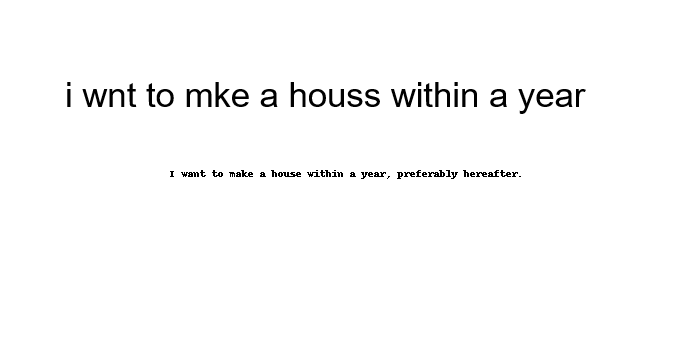


Download the corrected image:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# Run the processing function
process_image_and_correct()